----------- Warning: This notebook leverages the Keras library which requires a working implementation of the Theranos or Tensorflow backend ---------------

## Modeling

**Explain your reasoning behind the Algorithm used**

As it was stated, the Continuous Time-Series nature of this application makes it suitable for a Recurrent Neural Network (RNN). Recently a type of RNN called Long Short-Term Memory (LSTM) has been yielding great results, particularly in the application of time series regression and speech recognition (see [here](https://towardsdatascience.com/using-lstms-to-forecast-time-series-4ab688386b1f) and [here](https://machinelearningmastery.com/?s=lstm&post_type=post&submit=Search&paged=2)).

Despite no prior experience with deep learning, the author will implement a basic SimpleRNN and a basic LSTM, that will both significantly outperform the classical ML models.


In [1]:
# Importing libraries

## data handling
import numpy as np, pandas as pd

## visualizations
import matplotlib.pyplot as plt, seaborn as sns

# Machine learning

## utilities
# from 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from dask_ml.model_selection import GridSearchCV, RandomizedSearchCV
from dask.diagnostics import ProgressBar
## transformers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

# widening the cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# importing the dataset, the data shall keep its sequential nature (not be shuffled)
data = pd.read_csv("data_post_preprocessing.csv", parse_dates=True, index_col='date') 

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 6 columns):
TotalConsmp    19735 non-null float64
Press_mm_hg    19735 non-null float64
Windspeed      19735 non-null float64
Visibility     19735 non-null float64
H              19735 non-null float64
RTo            19735 non-null float64
dtypes: float64(6)
memory usage: 1.1 MB


In [4]:
# after EDA and Pre-processing we are left with 5 predictors, and a target variable
data.head(5)

,TotalConsmp,Press_mm_hg,Windspeed,Visibility,H,RTo
date,,,,,,
2016-01-11 17:00:00,90.0,733.5,7.000000,63.000000,45.534286,11.835000
2016-01-11 17:10:00,90.0,733.6,6.666667,59.166667,45.454524,11.959167
2016-01-11 17:20:00,80.0,733.7,6.333333,55.333333,45.344762,12.051667
2016-01-11 17:30:00,90.0,733.8,6.000000,51.500000,45.237143,12.146250
2016-01-11 17:40:00,100.0,733.9,5.666667,47.666667,45.230476,12.278750


## Formatting our sequential dataset and splitting into train and test sets

As per our problem definition we want to be able to predict the energy consumption in May 2016 given the consumption from January 11th 2016 to April 30th 2016.

In [5]:
# savings the indexes that will define the training & testing datasets. 
# May 1st 00:00:00 backwards is training, forwards is testing. 

idx_last_train = data.index.tolist().index(pd.Timestamp('2016-05-01 00:00:00')) - 1
idx_end = data.shape[0] - 1


assert data[data.index >= pd.Timestamp('2016-05-01 00:00:00')].shape[0] + idx_last_train == idx_end

In [6]:
print("The training data will be all the data collected from January 11 up to April 30th at 23:50:00, thus from index 0 to {}.\
       The testing data will go from May 01 00:00:00 to the end of the dataset, thus from index {} to {}."
       .format(idx_last_train, idx_last_train+1, idx_end))

The training data will be all the data collected from January 11 up to April 30th at 23:50:00, thus from index 0 to 15881.       The testing data will go from May 01 00:00:00 to the end of the dataset, thus from index 15882 to 19734.


In [7]:
# Separating the sequential data into X (predictors) and y (target)
X = data[['Press_mm_hg', 'Windspeed', 'Visibility', 'H', 'RTo']]
y = data[['TotalConsmp']]

In [8]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
X = np.array(X).reshape((len(X), 5))
X = scaler_X.fit_transform(X)
X

array([[0.09767442, 0.5       , 0.95384615, 0.74040412, 0.51527092],
       [0.1       , 0.47619048, 0.89487179, 0.73677424, 0.52014923],
       [0.10232558, 0.45238095, 0.83589744, 0.7317791 , 0.52378341],
       ...,
       [0.60232558, 0.26190476, 0.37435897, 0.73322176, 0.14138546],
       [0.60232558, 0.27380952, 0.38717949, 0.73388961, 0.14687567],
       [0.60232558, 0.28571429, 0.4       , 0.7312141 , 0.15010282]])

In [9]:
scaler_y = MinMaxScaler(feature_range=(0, 1))
y = np.array(y).reshape((len(y), 1)) 
y = scaler_y.fit_transform(y)
y

array([[0.07272727],
       [0.07272727],
       [0.06363636],
       ...,
       [0.24545455],
       [0.38181818],
       [0.39090909]])

In [10]:
# Making the training data all samples prior to May 1st 00:00:00 and the test data all samples after, including May 1st 00:00:00

X_train = X[0 : idx_last_train + 1, :]
X_test  = X[idx_last_train + 1 : idx_end, :]

y_train = y[1 : idx_last_train + 2]
y_test  = y[idx_last_train + 2: idx_end + 1]

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]


In [11]:
# configuring the input data to have the 3D array, (number of samples, number of features, time_steps), expected by the 
# Keras RNN implementation

X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))
X_train.shape

(15882, 5, 1)

## Recurrent Neural Network

The complexities of this problem require the power of deep learning, particularly of RNNs. This is outside the juristiction of scikit-learn and within the realms of the Keras library. 

In [12]:
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.core import Dense, Activation
from keras.layers import SimpleRNN, LSTM
from keras.regularizers import l1, l2
from keras.layers import TimeDistributed

Using TensorFlow backend.


In [13]:
# Optimizers on mostly standard configurations
sgd = SGD(lr = 0.0001, momentum = 0.95, nesterov = True)
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [14]:
# Simple RNN configuration
rnn = Sequential()
rnn.add( SimpleRNN(units = 10, activation = "tanh", input_shape = (5, 1)))
rnn.add(Dense( units = 50, activation = 'tanh', kernel_regularizer=l1(0.0001)))
rnn.add(Dense( units = 1, activation = 'tanh', kernel_regularizer=l1(0.0001)))
rnn.compile( loss = 'mean_squared_error', optimizer = sgd)

In [57]:
# LSTM RNN configuration
lstm = Sequential()
lstm.add(LSTM(200, activation='relu', input_shape=(5, 1), batch_input_shape = (15882, 5, 1), stateful=True))
lstm.add(Dense(100, activation='relu'))
lstm.add(Dense(1))
lstm.compile(loss='mse', optimizer=adam)

In [58]:
len(X_train)/2

7941.0

In [62]:
len(y_train)/6

2647.0

In [59]:
with ProgressBar():
#     rnn_hist = rnn.fit(X_train, y_train, batch_size=200, epochs =30, validation_split=0.2)
    lstm_hist = lstm.fit(X_train, y_train, epochs =30, validation_split=0.2, shuffle=False) #batch_size=50
    

ValueError: In a stateful network, you should only pass inputs with a number of samples that can be divided by the batch size. Found: 15882 samples

In [46]:
print("The simple RNN has a Mean Squared Error Loss on the test data of {}".format(rnn.evaluate(X_test , y_test ,batch_size =200)))

3852/3852 [==============================] - 1s 295us/step
The simple RNN has a Mean Squared Error Loss on the test data of 0.022615799506273224


In [47]:
print("The LSTM RNN has a Mean Squared Error Loss on the test data of {}".format(lstm.evaluate(X_test , y_test ,batch_size =200)))

ValueError: In a stateful network, you should only pass inputs with a number of samples that can be divided by the batch size. Found: 3852 samples

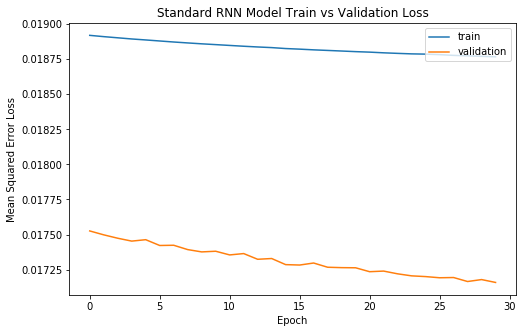

<Figure size 432x288 with 0 Axes>

In [291]:
plt.figure(figsize=(8,5))
plt.plot(rnn_hist.history['loss'])
plt.plot(rnn_hist.history['val_loss'])
plt.title('Standard RNN Model Train vs Validation Loss')
plt.ylabel('Mean Squared Error Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
plt.savefig("rnn_loss.png")

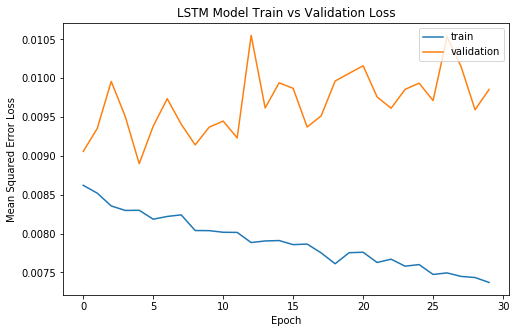

AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

In [292]:
plt.figure(figsize=(8,5))
plt.plot(lstm_hist.history['loss'])
plt.plot(lstm_hist.history['val_loss'])
plt.title('LSTM Model Train vs Validation Loss')
plt.ylabel('Mean Squared Error Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
plt.savefig("lstm_loss.png")

### Plotting Results

Here we will generate energy consumption predictions, bring them back to scale, and plot them.

In [218]:
# predicting and scaling back the TotalConsmp via RNN
rnn_pred = rnn.predict(X_test)
rnn_pred = scaler_y.inverse_transform(rnn_pred)
rnn_pred


array([[101.294586],
       [101.68932 ],
       [102.08967 ],
       ...,
       [145.2408  ],
       [144.27635 ],
       [143.99686 ]], dtype=float32)

In [219]:
# predicting and scaling back the TotalConsmp via LSTM
lstm_pred = lstm.predict(X_test)
lstm_pred = scaler_y.inverse_transform(lstm_pred)
lstm_pred

array([[91.96924 ],
       [91.878944],
       [91.61606 ],
       ...,
       [33.592594],
       [31.649927],
       [30.937649]], dtype=float32)

In [231]:
rnn_pred.shape, lstm_pred.shape

((3852, 1), (3852, 1))

In [238]:
data.iloc[-3852:, :]

,TotalConsmp,Press_mm_hg,Windspeed,Visibility,H,RTo
date,,,,,,
2016-05-01 00:10:00,60.0,763.716667,2.166667,38.166667,37.727500,16.058333
2016-05-01 00:20:00,50.0,763.733333,2.333333,36.333333,37.806190,16.066250
2016-05-01 00:30:00,50.0,763.750000,2.500000,34.500000,37.860476,16.082083
2016-05-01 00:40:00,60.0,763.766667,2.666667,32.666667,37.921429,16.102083
2016-05-01 00:50:00,40.0,763.783333,2.833333,30.833333,37.954762,16.075833
2016-05-01 01:00:00,60.0,763.800000,3.000000,29.000000,37.982381,16.056667
2016-05-01 01:10:00,50.0,763.850000,3.000000,28.500000,37.986667,16.132500
2016-05-01 01:20:00,60.0,763.900000,3.000000,28.000000,38.030000,16.223333
2016-05-01 01:30:00,50.0,763.950000,3.000000,27.500000,38.100476,16.280417


In [254]:
# creating a dataframe with the combination of both RNNs predictions, and appending the right datetimeindex
preds = pd.DataFrame({'rnn_pred':rnn_pred.reshape(-1), 'lstm_pred': lstm_pred.reshape(-1)}, index=data.iloc[-3852:, :].index)

results = pd.concat([data, preds], axis=1, join='outer')

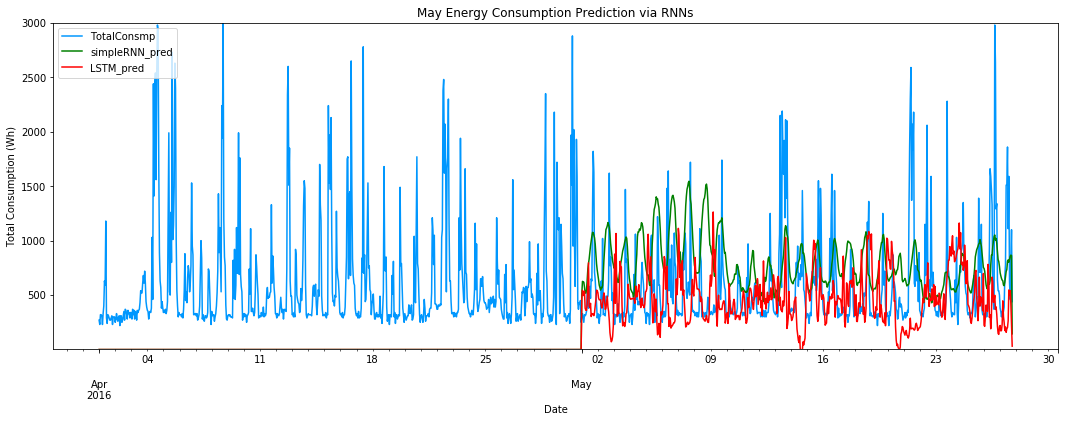

In [307]:
results.loc[results.index > 'Apr 1 16', ['TotalConsmp', 'rnn_pred', 'lstm_pred']].resample('H').sum().plot(figsize=(18, 6), color=('#0097FE', 'g', 'r'))
plt.title('May Energy Consumption Prediction via RNNs')
plt.ylabel('Total Consumption (Wh)')
plt.xlabel('Date')
plt.legend(['TotalConsmp', 'simpleRNN_pred', 'LSTM_pred'], loc='upper left')
plt.ylim(5, 3000)
plt.savefig('general_predictions.png', bbox_inches='tight')

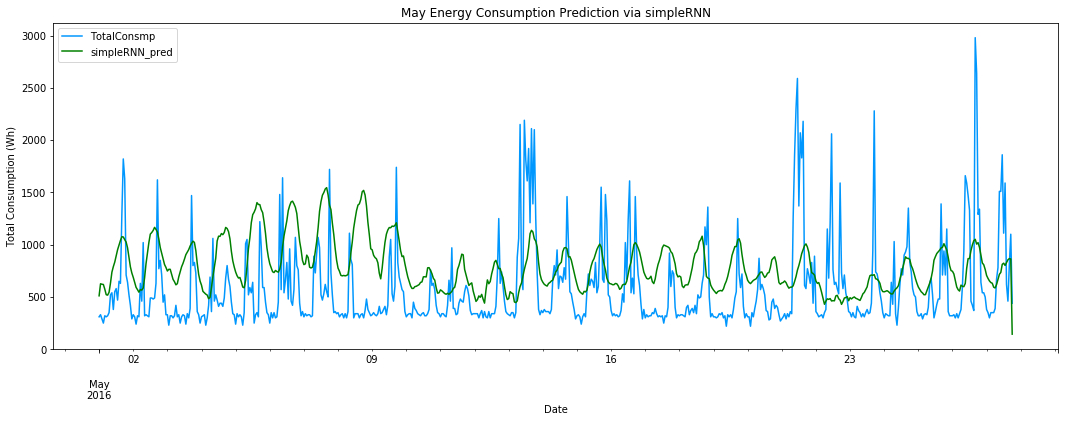

In [308]:
results.loc[results.index >= 'May 1 16', ['TotalConsmp', 'rnn_pred']].resample('H').sum().plot(figsize=(18, 6), color=('#0097FE', 'g'))
plt.title('May Energy Consumption Prediction via simpleRNN')
plt.ylabel('Total Consumption (Wh)')
plt.xlabel('Date')
plt.legend(['TotalConsmp', 'simpleRNN_pred'], loc='upper left')
plt.savefig('rnn_predictions.png', bbox_inches='tight')

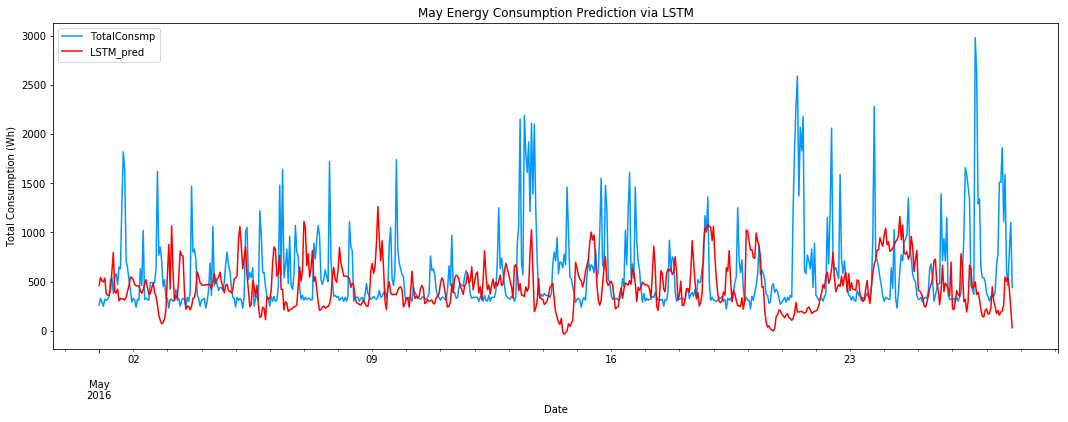

In [309]:
results.loc[results.index > 'May 1 16', ['TotalConsmp', 'lstm_pred']].resample('H').sum().plot(figsize=(18, 6), color=('#0097FE', 'r'))
plt.title('May Energy Consumption Prediction via LSTM')
plt.ylabel('Total Consumption (Wh)')
plt.xlabel('Date')
plt.legend(['TotalConsmp', 'LSTM_pred'], loc='upper left')
plt.savefig('lstm_predictions.png', bbox_inches='tight')

In [280]:
results.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Freq: 10T
Data columns (total 8 columns):
TotalConsmp    19735 non-null float64
Press_mm_hg    19735 non-null float64
Windspeed      19735 non-null float64
Visibility     19735 non-null float64
H              19735 non-null float64
RTo            19735 non-null float64
rnn_pred       3852 non-null float32
lstm_pred      3852 non-null float32
dtypes: float32(2), float64(6)
memory usage: 1.2 MB


In [281]:
results.to_csv('RNN_predictions.csv')

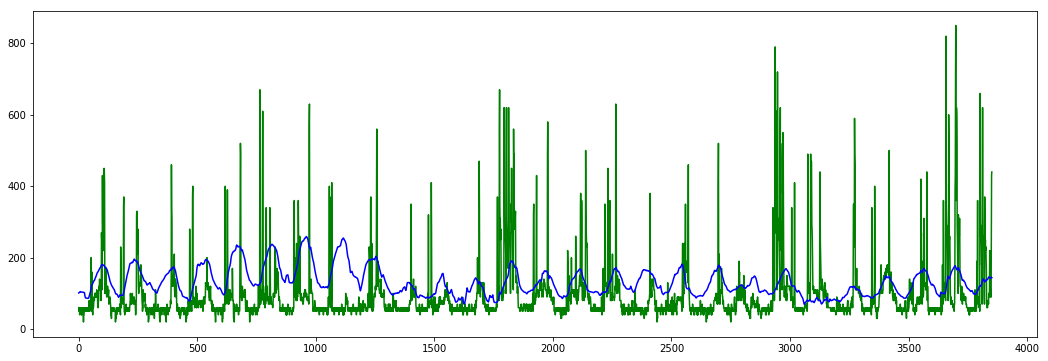

In [225]:
x = range(3852)
fig, ax = plt.subplots(figsize=(18,6))
plt.plot(x, y_test_b, 'g', x, rnn_pred, 'b')
plt.show()

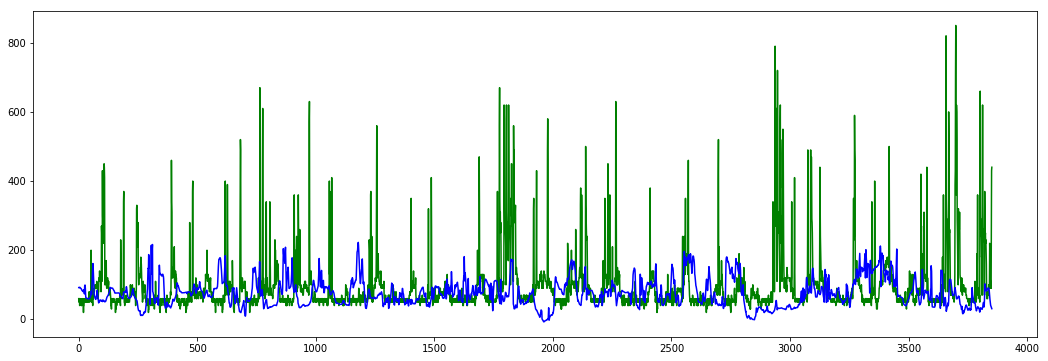

In [226]:
x = range(3852)
fig, ax = plt.subplots(figsize=(18,6))
plt.plot(x, y_test_b, 'g', x, lstm_pred, 'b')
plt.show()